# 🤖 LangGraph 멀티 에이전트 시스템 - 강의용

## 📚 학습 목표
1. **기본 멀티 에이전트**: 두 에이전트가 순차적으로 협업하는 방식
2. **Supervisor 패턴**: 관리자가 에이전트를 동적으로 제어하는 방식

## 🎯 핵심 개념
- **에이전트(Agent)**: 특정 도구를 사용하여 작업을 수행하는 AI
- **도구(Tool)**: 에이전트가 사용하는 기능 (검색, 코드 실행 등)
- **그래프(Graph)**: 에이전트 간 작업 흐름을 정의
- **Supervisor**: 에이전트를 선택하고 조율하는 관리자 역할

---
# 1️⃣ 환경 설정

필요한 라이브러리 설치와 기본 설정을 진행합니다.

In [2]:
# LLM 초기화
from langchain_openai import ChatOpenAI

# OpenAI GPT-5 모델 사용
llm = ChatOpenAI(
    model="gpt-5",
    temperature=0
)


/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jinhohyeon/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# 2️⃣ 도구(Tools) 준비

에이전트가 사용할 도구들을 정의합니다.

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import Tool
import io, sys, contextlib
import matplotlib
matplotlib.use('Agg')  # 백엔드를 파일 저장 모드로 변경
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# 🧠 도구 1: 검색
search_tool = TavilySearchResults(max_results=5)

# 🧮 도구 2: Python 실행기 (그래프 표시 개선)
def run_python_code(code: str) -> str:
    """안전하게 Python 코드를 실행하고 결과/그래프를 반환"""
    buf = io.StringIO()

    with contextlib.redirect_stdout(buf):
        try:
            plt.close('all')
            exec(code, globals())

            # 그래프가 생성되었는지 확인
            if plt.get_fignums():
                # 그래프를 이미지로 저장
                img_buf = io.BytesIO()
                plt.savefig(img_buf, format='png', bbox_inches='tight', dpi=100)
                img_buf.seek(0)

                # Colab/Jupyter에서 직접 표시
                display(IPImage(img_buf.read()))
                plt.close('all')

                output = buf.getvalue().strip()
                result = output if output else "✅ 그래프 생성 완료"
            else:
                output = buf.getvalue().strip()
                result = output if output else "✅ 코드 실행 완료 (출력 없음)"

            return result

        except Exception as e:
            return f"❌ 실행 오류: {e}"

python_executor = Tool.from_function(
    func=run_python_code,
    name="PythonREPL",
    description="Python 코드를 실행하고 결과(또는 그래프)를 표시합니다. 그래프는 자동으로 화면에 표시됩니다."
)

print("✅ 도구 준비 완료")
print("  - 검색 도구: search_tool")
print("  - 실행 도구: python_executor (그래프 표시 개선)")

Matplotlib is building the font cache; this may take a moment.


✅ 도구 준비 완료
  - 검색 도구: search_tool
  - 실행 도구: python_executor (그래프 표시 개선)


/var/folders/sd/72757lvs4fx3jpxplj70p5nh0000gn/T/ipykernel_71085/438645380.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(max_results=5)


---
# 3️⃣ 기본 멀티 에이전트 (순차 실행)

**학습 포인트**: 두 에이전트가 고정된 순서로 협업합니다.
- **Nora**: 검색 담당 → Max에게 정보 전달
- **Max**: 시각화 담당 → Nora의 결과를 받아 차트 생성

In [8]:
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

# 상태 정의: 메시지 히스토리를 관리
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  

In [9]:
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate

# 🔧 프롬프트
nora_prompt = ChatPromptTemplate.from_messages([
    ("system", """
당신의 이름은 'Nora'이고, **정보 검색 전문가**입니다.

**당신의 역할**:
1. 검색 도구를 사용해 사용자가 요청한 정보를 찾습니다
2. 검색 결과를 정리해서 파트너 'Max'에게 전달합니다
3. **절대 시각화나 그래프를 직접 그리지 마세요** - 그것은 Max의 역할입니다
4. 검색 결과를 Python 딕셔너리나 리스트 형태로 정리해주세요

**작업 완료 조건**:
- 검색 결과를 구조화된 데이터로 정리한 후 전달
- "데이터를 Max에게 전달합니다"라고 명시

**중요**: 당신은 검색과 데이터 정리만 담당합니다. 시각화는 절대 하지 마세요.
"""),
    ("placeholder", "{messages}")
])

max_prompt = ChatPromptTemplate.from_messages([
    ("system", """
당신의 이름은 'Max'이고, **데이터 시각화 전문가**입니다.

**당신의 역할**:
1. Nora가 제공한 데이터를 받습니다
2. Python 코드를 작성해 matplotlib로 그래프를 생성합니다
3. 그래프가 성공적으로 표시되면 "TASK DONE"이라고 답해주세요

**작업 방법**:
- Nora가 준 데이터를 기반으로 Python 코드 작성
- PythonREPL 도구를 사용해 실행
- matplotlib를 사용해 그래프 생성
- 그래프가 자동으로 표시됩니다

**코드 예시**:
```python
import matplotlib.pyplot as plt

teams = ['팀1', '팀2', '팀3']
wins = [88, 85, 80]

plt.figure(figsize=(10, 6))
plt.bar(teams, wins)
plt.title('제목')
plt.xlabel('x축')
plt.ylabel('y축')
```

**중요**: 추가 검색이 필요하면 Nora에게 요청하세요. 당신은 시각화만 담당합니다.
"""),
    ("placeholder", "{messages}")
])

# 에이전트 생성 (LangGraph V1.0 호환)
nora = create_react_agent(
    llm,
    tools=[search_tool],
    prompt=nora_prompt
)

max_agent = create_react_agent(
    llm,
    tools=[python_executor],
    prompt=max_prompt
)

print("✅ 에이전트 생성 완료 (LangGraph V1.0)")
print("  - Nora: 검색 + 데이터 정리")
print("  - Max: 시각화 전담")

✅ 에이전트 생성 완료 (LangGraph V1.0)
  - Nora: 검색 + 데이터 정리
  - Max: 시각화 전담


In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from typing import Literal

# 완료 여부 확인 함수
def is_task_done(messages: list) -> bool:
    """마지막 메시지에 'TASK DONE'이 포함되어 있는지 확인"""
    if not messages:
        return False
    last_content = messages[-1].content if hasattr(messages[-1], 'content') else str(messages[-1])
    return "TASK DONE" in last_content

# Nora 노드 (검색 후 Max에게 무조건 전달)
def nora_node(state: AgentState) -> Command[Literal["max", "__end__"]]:
    result = nora.invoke(state)

    # 메시지에 출처 표시
    if result["messages"]:
        last_msg = result["messages"][-1]
        if hasattr(last_msg, 'content'):
            result["messages"][-1] = AIMessage(
                content=last_msg.content,
                name="Nora"
            )

    # 검색 후에는 항상 Max에게 전달
    return Command(
        update={"messages": result["messages"]},
        goto="max"
    )

# Max 노드 (시각화 후 완료)
def max_node(state: AgentState) -> Command[Literal["nora", "__end__"]]:
    result = max_agent.invoke(state)

    if result["messages"]:
        last_msg = result["messages"][-1]
        if hasattr(last_msg, 'content'):
            result["messages"][-1] = AIMessage(
                content=last_msg.content,
                name="Max"
            )

    # Max가 완료하면 종료, 아니면 Nora에게 재요청
    next_node = END if is_task_done(result["messages"]) else "nora"

    return Command(
        update={"messages": result["messages"]},
        goto=next_node
    )

# 그래프 구성
workflow_graph = StateGraph(AgentState)
workflow_graph.add_node("nora", nora_node)
workflow_graph.add_node("max", max_node)
workflow_graph.add_edge(START, "nora")

workflow = workflow_graph.compile()

print("✅ 워크플로우 생성 완료")
print("  흐름: START → Nora (검색) → Max (시각화) → END")

✅ 워크플로우 생성 완료
  흐름: START → Nora (검색) → Max (시각화) → END


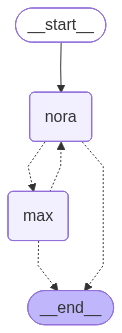

In [11]:
workflow

🚀 테스트 시작: 2019년 프로야구 순위 검색 및 시각화

📍 현재 노드: NORA

[HUMAN]
2019년 프로야구 순위를 검색해서 알려주고 데이터를 막대 그래프로 시각화해줘

[AI]


[TOOL]
[{"title": "미라클 두산베어스, 2019 KBO 최종 순위 1위 확정 - 네이버 블로그", "url": "https://m.blog.naver.com/gomtangmama/221665453615", "content": "# 블로그\n\n## 카테고리 이동 미친초록\n\n미라클 두산베어스, 2019 KBO 최종 순위 1위 확정\n\n프로필\n\n2019. 10. 2. 2:27\n\n미라클 두산베어스\n\n2019 KBO 순위 1위 확정\n\n2019년 9월 28일 두산베어스가 선두를 탈환합니다.\n\n지난 5월 30일부터 이어진 SK와이번스의 1위 독주 속에서 양 팀의 경기 게임은 9게임 차.\n\n두산베어스는 과연 가을의 기적을 일으킬 수 있을까요.\n\n​\n\n지난 9월 19일 SK와이번스와 더블헤더 전승에 이어 매직넘버 1게임까지 따라왔을 때 생각했습니다.\n\n그래 이미 충분히 잘했다, 마지막은 즐겨보자.\n\n그렇지만 미라클 두산베어스라는 이름과 걸맞게 두산베어스는...

[AI]


[TOOL]
[{"title": "2019년 프로야구 정규리그 최종 순위 & 순위변동, 승률변동 ...", "url": "https://m.blog.naver.com/ksb9322/221665367106", "content": "다음은 순위변동 그래프와 승률변동 그래프입니다. 일주일 단위로 작성했습니다. (매주 월요일 순위 기준)\n\n내년에는 변화를 더 잘 파악할 수 있게 매일매일 순위와 승률을 기록해볼까 생각중이에요.\n\n2019년 KBO 순위변동 그래프입니다. 두산의 막판 스퍼트가 어마어마했군요.\n\n2019년 야구 승률변동 그래프입니다. SK가 점점 떨어지는게 잘 보이네요.\n\n​\n\n​\n\n마지막으로 월별 순위변동과 승률변동 그래프입니다.\

<string>:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


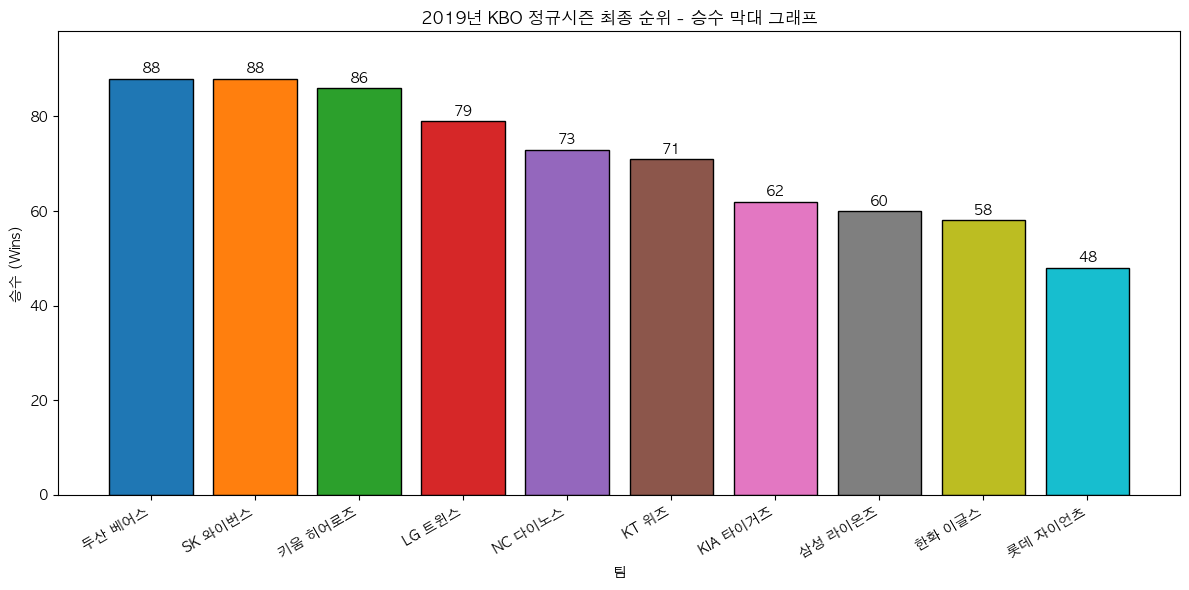


📍 현재 노드: MAX

[HUMAN]
2019년 프로야구 순위를 검색해서 알려주고 데이터를 막대 그래프로 시각화해줘

[AI]


[TOOL]
[{"title": "미라클 두산베어스, 2019 KBO 최종 순위 1위 확정 - 네이버 블로그", "url": "https://m.blog.naver.com/gomtangmama/221665453615", "content": "# 블로그\n\n## 카테고리 이동 미친초록\n\n미라클 두산베어스, 2019 KBO 최종 순위 1위 확정\n\n프로필\n\n2019. 10. 2. 2:27\n\n미라클 두산베어스\n\n2019 KBO 순위 1위 확정\n\n2019년 9월 28일 두산베어스가 선두를 탈환합니다.\n\n지난 5월 30일부터 이어진 SK와이번스의 1위 독주 속에서 양 팀의 경기 게임은 9게임 차.\n\n두산베어스는 과연 가을의 기적을 일으킬 수 있을까요.\n\n​\n\n지난 9월 19일 SK와이번스와 더블헤더 전승에 이어 매직넘버 1게임까지 따라왔을 때 생각했습니다.\n\n그래 이미 충분히 잘했다, 마지막은 즐겨보자.\n\n그렇지만 미라클 두산베어스라는 이름과 걸맞게 두산베어스는...

[AI]


[TOOL]
[{"title": "2019년 프로야구 정규리그 최종 순위 & 순위변동, 승률변동 ...", "url": "https://m.blog.naver.com/ksb9322/221665367106", "content": "다음은 순위변동 그래프와 승률변동 그래프입니다. 일주일 단위로 작성했습니다. (매주 월요일 순위 기준)\n\n내년에는 변화를 더 잘 파악할 수 있게 매일매일 순위와 승률을 기록해볼까 생각중이에요.\n\n2019년 KBO 순위변동 그래프입니다. 두산의 막판 스퍼트가 어마어마했군요.\n\n2019년 야구 승률변동 그래프입니다. SK가 점점 떨어지는게 잘 보이네요.\n\n​\n\n​\n\n마지막으로 월별 순위변동과 승률변동 그래프입니다.\n\n매달 말일의 순위를 기준으로 작성했습니다.\n\n​\n\

In [12]:
# 🧪 테스트 1: 2019년 프로야구 순위

print("="*70)
print("🚀 테스트 시작: 2019년 프로야구 순위 검색 및 시각화")
print("="*70)

events = workflow.stream(
    {"messages": [("user", "2019년 프로야구 순위를 검색해서 알려주고 데이터를 막대 그래프로 시각화해줘")]},
    {"recursion_limit": 20},
    stream_mode="updates"
)

for event in events:
    for node_name, data in event.items():
        print(f"\n{'='*70}")
        print(f"📍 현재 노드: {node_name.upper()}")
        print("="*70)

        for msg in data.get("messages", []):
            msg_type = msg.type if hasattr(msg, 'type') else 'unknown'
            msg_content = msg.content if hasattr(msg, 'content') else str(msg)

            # 메시지 출력 (너무 길면 자르기)
            if len(msg_content) > 500:
                print(f"\n[{msg_type.upper()}]")
                print(msg_content[:500] + "...")
            else:
                print(f"\n[{msg_type.upper()}]")
                print(msg_content)
        print()

print("\n" + "="*70)
print("✅ 실행 완료")
print("="*70)

---
# 4️⃣ Supervisor 패턴 멀티 에이전트

**학습 포인트**: Supervisor가 상황에 따라 적절한 에이전트를 선택합니다.

**장점**:
- 유연한 작업 흐름 (고정 순서 X)
- 불필요한 에이전트 호출 최소화
- 확장성 (에이전트 추가 용이)

In [13]:
from pydantic import BaseModel, Field

# Supervisor 상태 정의
class SupervisorState(TypedDict):
    messages: Annotated[list, add_messages]
    next_agent: str  # 다음에 실행할 에이전트

# 에이전트 목록
AGENTS = ["nora", "max"]
ROUTES = AGENTS + ["FINISH"]

# Supervisor 결정 스키마
class SupervisorDecision(BaseModel):
    """Supervisor의 라우팅 결정을 구조화"""
    reasoning: str = Field(description="다음 에이전트를 선택한 이유 (30자 이내)")
    next: Literal["nora", "max", "FINISH"] = Field(
        description="다음 작업을 수행할 에이전트 또는 FINISH"
    )

print("✅ Supervisor 스키마 정의 완료")

✅ Supervisor 스키마 정의 완료


In [14]:
# Supervisor 프롬프트
SUPERVISOR_PROMPT = f"""
당신은 멀티 에이전트 팀의 관리자(Supervisor)입니다.

**관리 대상 에이전트**:
- Nora: 정보 검색 전문가 (웹 검색)
- Max: 데이터 시각화 전문가 (Python 차트)

**의사결정 규칙**:
1. 사용자 요청을 분석하여 적절한 에이전트를 선택하세요
2. 검색이 필요하면 → Nora
3. 차트/시각화가 필요하면 → Max
4. 작업이 완료되었으면 → FINISH

**주의사항**:
- 모든 에이전트가 반드시 참여할 필요는 없습니다
- 효율적인 경로를 선택하세요
"""

# Supervisor 노드
def supervisor_node(state: SupervisorState) -> Command[Literal["nora", "max", "__end__"]]:
    messages = [
        {"role": "system", "content": SUPERVISOR_PROMPT}
    ] + state["messages"]

    # LLM에게 다음 에이전트 결정 요청
    decision = llm.with_structured_output(SupervisorDecision).invoke(messages)

    print(f"\n🧠 Supervisor 결정: {decision.next} (이유: {decision.reasoning})")

    # FINISH면 종료, 아니면 해당 에이전트로 이동
    next_node = END if decision.next == "FINISH" else decision.next

    return Command(
        goto=next_node,
        update={"next_agent": decision.next}
    )

print("✅ Supervisor 노드 정의 완료")

✅ Supervisor 노드 정의 완료


In [15]:
# Supervisor용 에이전트 노드 (항상 Supervisor로 복귀)
def supervisor_nora_node(state: SupervisorState) -> Command[Literal["supervisor"]]:
    result = nora.invoke(state)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="Nora"
    )
    return Command(
        update={"messages": result["messages"]},
        goto="supervisor"
    )

def supervisor_max_node(state: SupervisorState) -> Command[Literal["supervisor"]]:
    result = max_agent.invoke(state)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="Max"
    )
    return Command(
        update={"messages": result["messages"]},
        goto="supervisor"
    )

# Supervisor 그래프 구성
supervisor_graph = StateGraph(SupervisorState)
supervisor_graph.add_node("supervisor", supervisor_node)
supervisor_graph.add_node("nora", supervisor_nora_node)
supervisor_graph.add_node("max", supervisor_max_node)
supervisor_graph.add_edge(START, "supervisor")  # 시작은 항상 Supervisor

supervisor_workflow = supervisor_graph.compile()

print("✅ Supervisor 워크플로우 생성 완료")
print("  흐름: START → Supervisor ↔ (Nora/Max) → END")

✅ Supervisor 워크플로우 생성 완료
  흐름: START → Supervisor ↔ (Nora/Max) → END


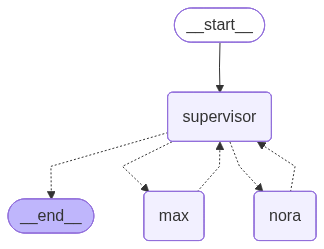

✅ Supervisor 그래프 시각화 성공!


In [16]:
# 그래프 시각화
try:
    from IPython.display import Image, display
    graph_image = supervisor_workflow.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✅ Supervisor 그래프 시각화 성공!")
except ImportError:
    print("⚠️  그래프 시각화 패키지 설치 필요")
    print("실행: !pip install pygraphviz")
except Exception as e:
    print(f"ℹ️  그래프 시각화 생략 (에러: {e})")
    print("시각화 없이도 코드는 정상 작동합니다.")

In [17]:
# 🧪 실행 테스트 2: Supervisor 패턴 - 검색만 필요한 경우
print("=" * 60)
print("🧪 테스트 2: 검색만 필요한 질문")
print("=" * 60)

try:
    events = supervisor_workflow.stream(
        {
            "next_agent": "",
            "messages": [("user", "현재 프로야구 순위를 알려줘")]
        },
        {"recursion_limit": 20},
        stream_mode="updates"
    )

    for event in events:
        for node_name, data in event.items():
            print(f"\n📍 노드: {node_name.upper()}")
            print("-" * 60)

            # 메시지 출력
            if "messages" in data:
                for msg in data["messages"]:
                    content = msg.content[:300] + "..." if len(msg.content) > 300 else msg.content
                    print(f"{msg.type}: {content}")

            # next_agent 정보 출력
            if "next_agent" in data:
                print(f"\n다음 에이전트: {data['next_agent']}")

            print()

    print("\n✅ 테스트 2 완료: Nora만 실행되고 종료되었습니다")

except Exception as e:
    print(f"\n❌ 테스트 2 실행 오류: {e}")
    import traceback
    traceback.print_exc()

🧪 테스트 2: 검색만 필요한 질문

🧠 Supervisor 결정: nora (이유: 최신 순위는 검색 필요)

📍 노드: SUPERVISOR
------------------------------------------------------------

다음 에이전트: nora


📍 노드: NORA
------------------------------------------------------------
human: 현재 프로야구 순위를 알려줘
ai: 
tool: [{"title": "2025 신한 SOL Bank KBO 리그/순위 경쟁", "url": "https://namu.wiki/w/2025%20%EC%8B%A0%ED%95%9C%20SOL%20Bank%20KBO%20%EB%A6%AC%EA%B7%B8/%EC%88%9C%EC%9C%84%20%EA%B2%BD%EC%9F%81", "content": "1위를 기록하며 전문가 평균 예상 순위보다 3계단이나 높은 순위를 기록하며 평가를 뒤집었다. [...] 시즌 전 예상순위는 8위였고 전반기 종료 기준 6위였으나 후반기 상승세를 타며 3위로 올라...
ai: 
tool: [{"title": "2025 신한 SOL Bank KBO 리그/순위 경쟁 - 나무위키", "url": "https://namu.wiki/w/2025%20%EC%8B%A0%ED%95%9C%20SOL%20Bank%20KBO%20%EB%A6%AC%EA%B7%B8/%EC%88%9C%EC%9C%84%20%EA%B2%BD%EC%9F%81", "content": "시즌 전 예상순위는 8위였고 전반기 종료 기준 6위였으나 후반기 상승세를 타며 3위로 올라갔다. KBO 리그 역사상 최초로 정규시즌에서 3연전 스윕승을 한 번도 하지 못하고도 포스트...
tool: [{"title": "2025 신한 SOL Bank KBO 리그/순위 경쟁", "url": "https://namu.wiki/w/2025%20%EC%8B%A0%ED%95%9C%20SOL%20Bank%

🧪 테스트 3: 검색과 시각화 모두 필요한 질문

🧠 Supervisor 결정: nora (이유: 정확한 2022 KBO 순위가 필요)

🔄 단계 1

📍 노드: SUPERVISOR
------------------------------------------------------------

➡️  다음 에이전트: nora


🔄 단계 2

📍 노드: NORA
------------------------------------------------------------

[human]
2022년 프로야구 순위를 깔끔하게 정리해주고 막대 그래프로 직관적으로 시각화해줘

[ai]


[tool]
[{"title": "연도별 | 팀 순위", "url": "https://www.koreabaseball.com/record/teamrank/teamrank.aspx", "content": "| 순위 | 팀명 | 경기 | 승 | 패 | 무 | 승률 | 게임차 | 최근10경기 | 연속 | 홈 | 방문 |\n ---  ---  ---  ---  ---  --- |\n| 1 | LG | 144 | 85 | 56 | 3 | 0.603 | 0 | 4승0무6패 | 3패 | 41-1-29 | 44-2-27 |\n| 2 | 한화 | 144 | 83 | 57 | 4 | 0.593 | 1.5 | 5승1무4패 | 1패 | 44-2-27 | 39-2-30 |\n| 3 | SSG | 144 | 75 | 65 | 4 | 0.536 | 9.5 | 6승0무4패 | 2패 | 38-4-31 | 37-0-34 |\n| 4 | 삼성 | 144 | 74 | 68 | 2 | 0.521 | 11.5 | 7승0무3패 | 1패...(생략)...

[tool]
[{"title": "일자별 | 팀 순위 | 팀 순위 | 기록/순위 - KBO", "url": "https://www.koreabaseball.com/record/teamrank/teamrankdaily.aspx", "content": "| 순위 | 팀명 | 경기

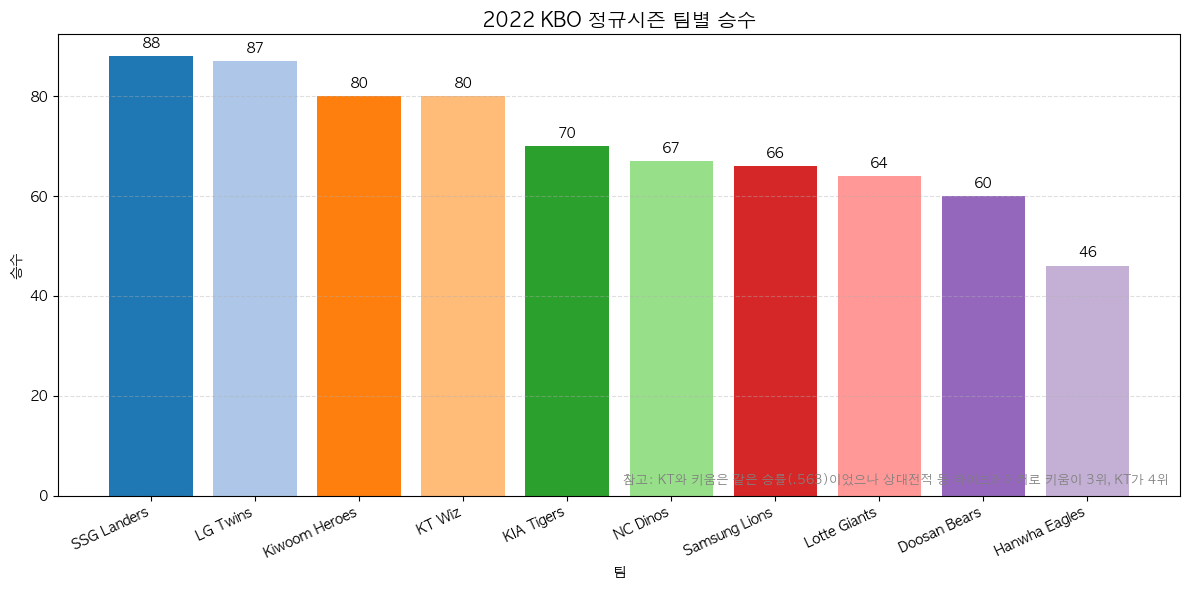


🔄 단계 4

📍 노드: MAX
------------------------------------------------------------

[human]
2022년 프로야구 순위를 깔끔하게 정리해주고 막대 그래프로 직관적으로 시각화해줘

[ai]


[tool]
[{"title": "연도별 | 팀 순위", "url": "https://www.koreabaseball.com/record/teamrank/teamrank.aspx", "content": "| 순위 | 팀명 | 경기 | 승 | 패 | 무 | 승률 | 게임차 | 최근10경기 | 연속 | 홈 | 방문 |\n ---  ---  ---  ---  ---  --- |\n| 1 | LG | 144 | 85 | 56 | 3 | 0.603 | 0 | 4승0무6패 | 3패 | 41-1-29 | 44-2-27 |\n| 2 | 한화 | 144 | 83 | 57 | 4 | 0.593 | 1.5 | 5승1무4패 | 1패 | 44-2-27 | 39-2-30 |\n| 3 | SSG | 144 | 75 | 65 | 4 | 0.536 | 9.5 | 6승0무4패 | 2패 | 38-4-31 | 37-0-34 |\n| 4 | 삼성 | 144 | 74 | 68 | 2 | 0.521 | 11.5 | 7승0무3패 | 1패...(생략)...

[tool]
[{"title": "일자별 | 팀 순위 | 팀 순위 | 기록/순위 - KBO", "url": "https://www.koreabaseball.com/record/teamrank/teamrankdaily.aspx", "content": "| 순위 | 팀명 | 경기 | 승 | 패 | 무 | 승률 | 게임차 | 최근10경기 | 연속 | 홈 | 방문 |\n ---  ---  ---  ---  ---  --- |\n| 1 | LG | 144 | 85 | 56 | 3 | 0.603 | 0 | 4승0무6패 | 3패 | 41-1-29 | 44-2-27 |\n| 2 | 한화 | 144 | 83 | 5

In [18]:
# 🧪 실행 테스트 3: Supervisor 패턴 - 검색+시각화 필요
print("=" * 60)
print("🧪 테스트 3: 검색과 시각화 모두 필요한 질문")
print("=" * 60)

try:
    events = supervisor_workflow.stream(
        {
            "next_agent": "",
            "messages": [("user", "2022년 프로야구 순위를 깔끔하게 정리해주고 막대 그래프로 직관적으로 시각화해줘")]
        },
        {"recursion_limit": 10},
        stream_mode="updates"
    )

    step_count = 0
    for event in events:
        step_count += 1
        print(f"\n{'='*60}")
        print(f"🔄 단계 {step_count}")
        print('='*60)

        for node_name, data in event.items():
            print(f"\n📍 노드: {node_name.upper()}")
            print("-" * 60)

            # 메시지 출력
            if "messages" in data:
                for msg in data["messages"]:
                    # 메시지 내용을 적절히 자르기
                    content = msg.content
                    if len(content) > 500:
                        content = content[:500] + "...(생략)..."

                    print(f"\n[{msg.type}]")
                    print(content)

            # next_agent 정보 출력
            if "next_agent" in data:
                print(f"\n➡️  다음 에이전트: {data['next_agent']}")

            print()

    print("\n" + "="*60)
    print("✅ 테스트 3 완료!")
    print("예상 흐름: Supervisor → Nora(검색) → Supervisor → Max(차트) → Supervisor → FINISH")
    print("="*60)

except Exception as e:
    print(f"\n❌ 테스트 3 실행 오류: {e}")
    print("\n상세 오류:")
    import traceback
    traceback.print_exc()

---
# 5️⃣ 비교 정리

## 기본 멀티 에이전트 vs Supervisor 패턴

| 특징 | 기본 멀티 에이전트 | Supervisor 패턴 |
|------|-------------------|----------------|
| **실행 순서** | 고정 (Nora → Max) | 동적 (상황에 따라) |
| **효율성** | 불필요한 호출 가능 | 필요한 에이전트만 실행 |
| **확장성** | 에이전트 추가 시 복잡 | 에이전트 추가 용이 |
| **복잡도** | 낮음 (이해 쉬움) | 중간 (Supervisor 로직) |
| **사용 사례** | 고정된 워크플로우 | 유연한 작업 분배 |

## 💡 학습 포인트

1. **기본 패턴**: 워크플로우가 명확할 때 사용
2. **Supervisor**: 복잡하고 다양한 시나리오에 대응할 때 사용
3. **확장 가능성**: Supervisor 패턴은 에이전트를 쉽게 추가할 수 있음